# Segmenting Credit Card Customers with K-Means Clustering

This project analyzes a dataset of credit card customer information to segment customers into groups in order to tailor business strategies. The goal is to define unique customer segments and summarize key characteristics using the K-means clustering algorithm. 

The dataset contains features like income, credit limit, account usage, gender, and marital status. By feeding these features into the K-means algorithm, distinct customer segments emerge based on credit risk, spending habits, demographics, and marketing potential. 

Initial analysis identified 5 unique clusters: average clients, high-risk low income married females, high-value low-risk male clients, high-risk low income single females, and middle income mixed gender clients. These groups present opportunities to adjust credit limits, target rewards programs, and provide financial counseling. This segmentation demonstrates how machine learning can provide actionable insights.

The rest of the report will detail the approach, methodology, and interpretation of key results. Segmenting customers in this way is crucial for developing customized business strategies that maximize value.

In [1]:
# Importing main libraries
import numpy as np
import pandas as pd

In [2]:
# Reading in the dataset
customers = pd.read_csv('customer_segmentation.csv')

customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000


The dataset contains the following features:
- customer_id: unique identifier for each customer.
- age: customer age in years.
- gender: customer gender (M or F).
- dependent_count: number of dependents of each customer.
- education_level: level of education ("High School", "Graduate", etc.).
- marital_status: marital status ("Single", "Married", etc.).
- estimated_income: the estimated income for the customer.
- months_on_book: time as a customer in months.
- total_relationship_count: number of times the customer contacted the company.
- months_inactive_12_mon: number of months the customer did not use the credit card in the last 12 months.
- credit_limit: customer's credit limit.
- total_trans_amount: the overall amount of money spent on the card by the customer.
- total_trans_count: the overall number of times the customer used the card.
- avg_utilization_ratio: daily average utilization ratio.

Except for customer_id column, all other features will be useful for our analysis.

## Exploratory Data Analysis

In [3]:
# Exploring data type of each column
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are no missing values in the dataset.

There are three categorical characteristics: gender, education level, and marital status, which will need to be converted later.

Next, we will plot the distribution of values for each column. We will use a kernel density plot for numeric variables and a histogram for categorical variables.

In [4]:
# Importing matplotlib for visualization
import matplotlib.pyplot as plt

%matplotlib inline
# Enables Jupyter to display graphs

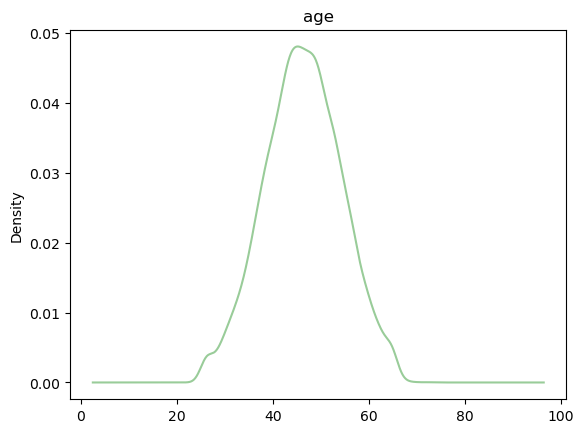

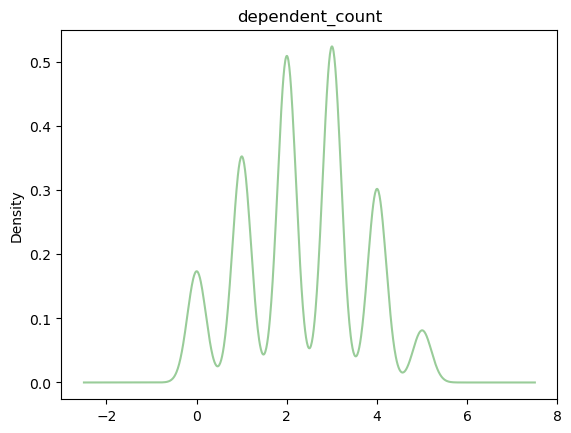

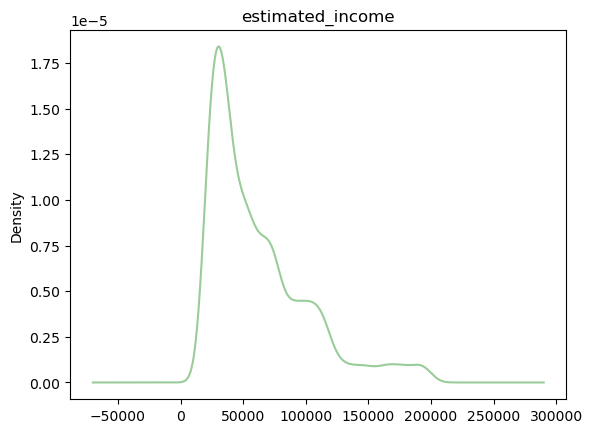

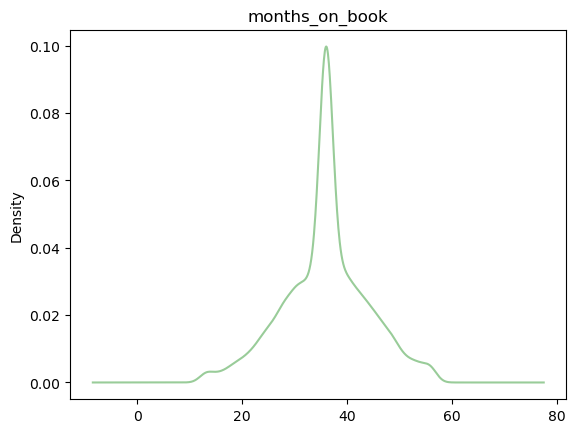

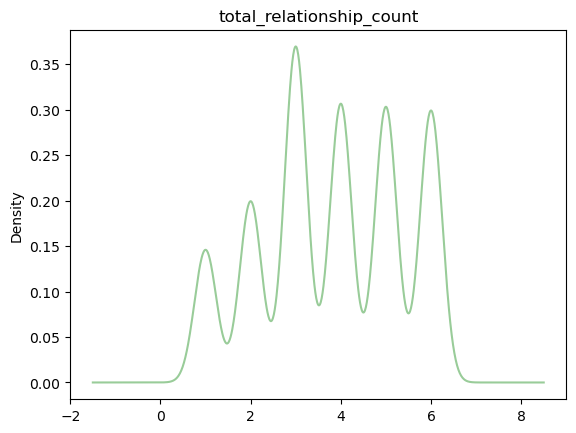

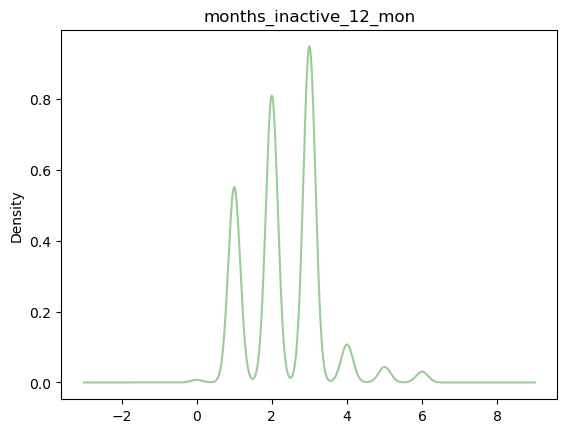

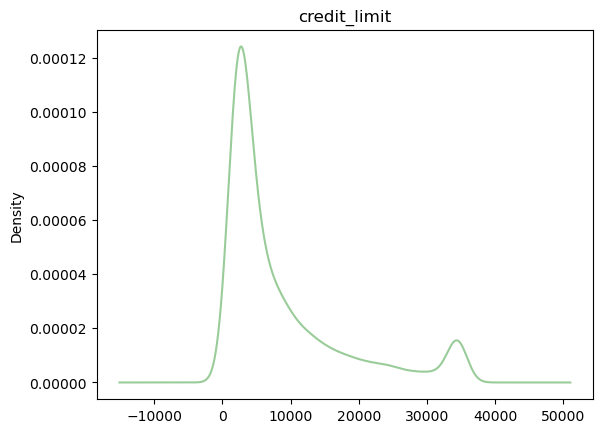

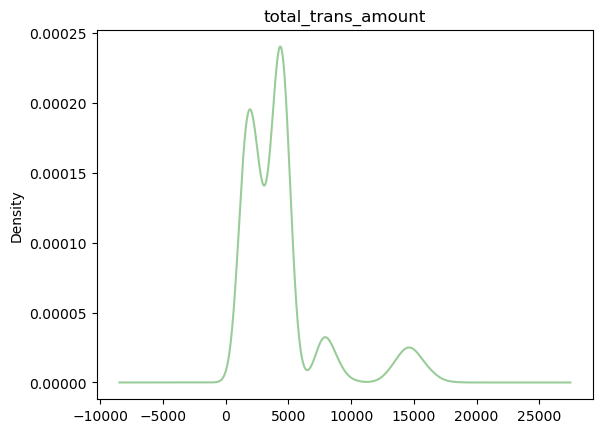

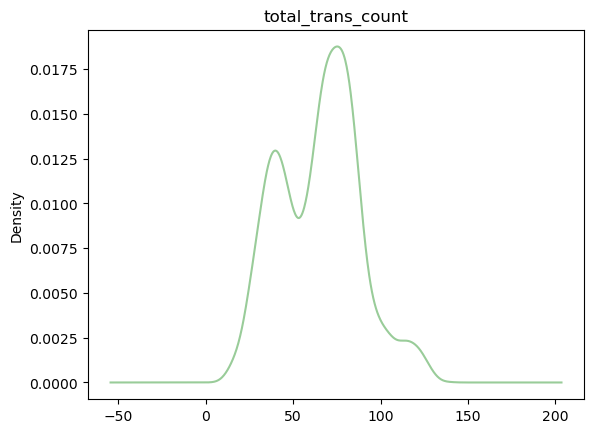

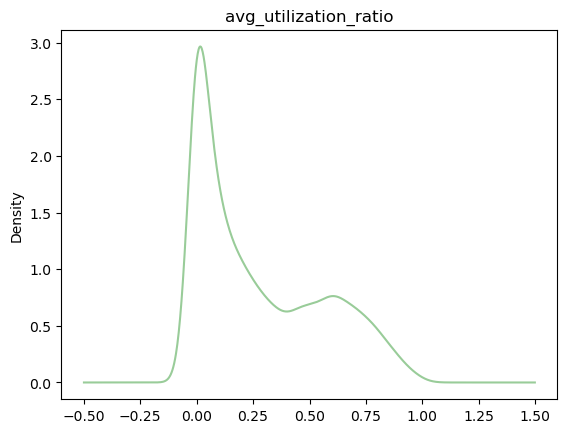

In [5]:
# Selecting numerical columns except the customer_id column
customers_numeric = customers.select_dtypes(include='number').iloc[:,1:].columns

# Plotting distributions
for col in customers_numeric:
    customers[col].plot(kind='kde', color='green', alpha=0.4)
    plt.title(col)
    plt.show()

Given the distributions, we can draw some quick conclusions:
- Age and months on book are distributed symmetrically around the mode.
- Estimated income, credit limit, average utilization ratio are heavily skewed to the right (the mode is close to zero).
- The distributions of total transaction amout, total transaction count, and credit limit show two distinct peaks (one of which is close to zero).

Since the range of dependent count, total relationship count, and months inactive consists of a limited number of values, we could use a bar chart to plot these characteristics.

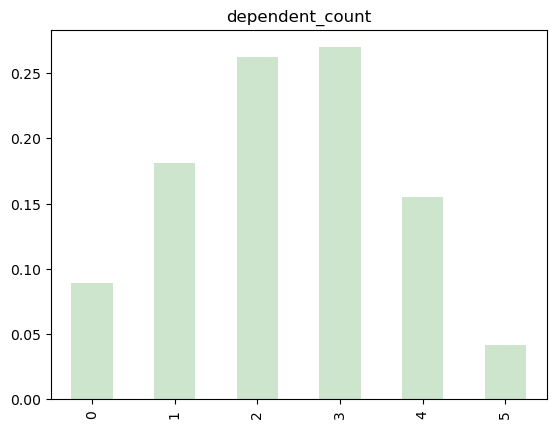

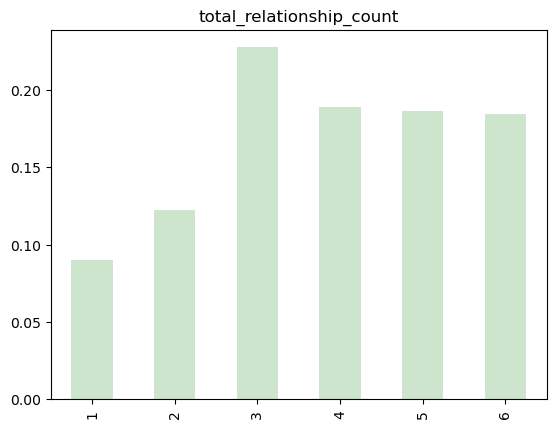

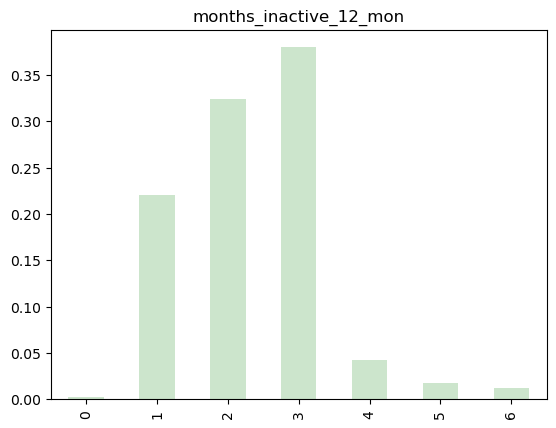

In [6]:
# Selecting the columns
customers_numeric_2 = ['dependent_count', 'total_relationship_count', 'months_inactive_12_mon']

# Plotting distributions
for col in customers_numeric_2:
    customers[col].value_counts(normalize=True).sort_index().plot.bar(color='green', alpha=0.2)
    plt.title(col)
    plt.show()

Dependent count appears to be normally distributed around the mean, while total relationship count and months inactive are skewed to the left and right, respectively.

## Feature Engineering

First, we will convert categorical variables to numerical variables.

In [7]:
customers['gender'].value_counts(dropna=False)

F    5358
M    4769
Name: gender, dtype: int64

Gender (M or F) can be directly converted to 1/0 variable. 

In [8]:
customers['education_level'].value_counts(dropna=False)

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

Education level is an ordinal variable, so we can convert education levels to numbers while preserving the order.

In [9]:
customers['marital_status'].value_counts(dropna=False)

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

Marital status can be converted to a dummy variable using one-hot encoding.

In [10]:
customers_1 = customers.copy()

# Replacing M/F gender with 1/0 respectively
customers_1['gender'].replace({'M':1, 'F':0}, inplace=True)

# Replacing levels of education from Uneducated to Doctorate with integers from 0 to 5 respectively
customers_1['education_level'].replace({'Uneducated':0,
                               'High School':1,
                               'College':2,
                               'Graduate':3,
                               'Post-Graduate':4,
                               'Doctorate':5}, inplace=True)

# Replacing values in marital_status with dummy variables
customers_1 = pd.get_dummies(customers_1, drop_first=True)

customers_1

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


## Scaling the Data

Next, we'll transform the data so that it's all on the same scale.

In [11]:
# Creating the copy of the dataset without the id column
customers_2 = customers_1.drop('customer_id', axis=1).copy()

customers_2

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


In [12]:
# Importing StandardScaler from scikit-learn
from sklearn.preprocessing import StandardScaler

# Scaling the dataset
scaler = StandardScaler()
scaler.fit(customers_2)

customers_2_scaled = scaler.transform(customers_2)

# Transforming the result back to DataFrame
customers_3_scaled = pd.DataFrame(customers_2_scaled)

customers_3_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.458314,1.059956,-0.266547,0.662787,-0.281380,0.509840,-0.522785,-0.337598,-0.509330,3.259358,2.221481,0.678714,-0.928214,1.252337,-0.282609
10123,-0.664382,1.059956,-0.266547,0.662787,-0.560775,-1.368442,0.120579,-0.337598,-0.479181,1.283475,0.176440,0.856458,-0.928214,-0.798507,-0.282609
10124,-0.290150,-0.943436,-1.036462,-0.752211,-0.738571,0.008965,0.763943,0.651940,-0.354626,1.732994,-0.207005,-0.997155,1.077338,-0.798507,-0.282609
10125,-2.036565,1.059956,-0.266547,0.662787,-0.382978,0.008965,0.120579,0.651940,-0.368710,1.174848,-0.121795,-0.997155,-0.928214,-0.798507,3.538459


## Choosing K

Next, we will decide on the best number of clusters to use for segmentation.

We will create several models and calculate the inertia from each of them. Then we'll be able to plot the elbow curve and decide how many clusters to use to segment customers.

In [13]:
# Importing KMeans from scikit-learn
from sklearn.cluster import KMeans

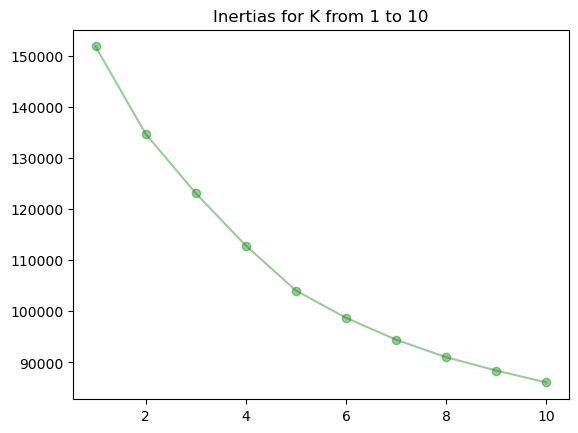

In [14]:
# Creating empty list to store resulting inertias
inertias = []

# We will loop over potential values of k in the range from 1 to 10
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    
    # Fitting the model on the scaled data set
    clusters = model.fit_predict(customers_3_scaled)
    
    # Saving resulting inertia in the list
    inertias.append(model.inertia_)
    
# Plotting the inertias
plt.plot(range(1, 11), inertias, marker='o', color='green', alpha=0.4)
plt.title('Inertias for K from 1 to 10')
plt.show()

Using the elbow rule, we will use k = 5 for our model.

In [15]:
model = KMeans(n_clusters=5, random_state=101)
    
# Fitting the model with 5 clusters on the scaled data set
clusters = model.fit_predict(customers_3_scaled)

print(clusters)

[2 3 2 ... 1 0 1]


## Analyzing the Results

First, we will add the resulting clusters to our initial dataset.

In [16]:
# Changing the cluster numbering from 0-4 to 1-5 for better display
customers['cluster'] = clusters + 1

customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,cluster
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,3
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,4
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,5
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,4
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,2
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,1


Next, we group each numeric variable by cluster and plot the results.

In [17]:
customers_grouping = customers.drop('customer_id', axis=1).groupby('cluster').mean()

customers_grouping

,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
cluster,,,,,,,,,,
1,45.655738,2.543716,61613.387978,35.260929,3.800546,2.336066,9195.358060,4478.419399,65.994536,0.259284
2,47.049368,2.308845,46154.569498,36.558037,4.021746,2.343227,4154.750485,3227.982662,57.484279,0.373399
3,46.846981,2.528147,112430.399181,36.310133,4.081372,2.372057,19228.461464,3206.411975,56.208291,0.079524
4,45.684228,2.226992,45708.943089,35.403577,3.931057,2.367805,4855.640780,3754.474797,65.488130,0.327817
5,45.271028,2.339564,68802.699896,35.112150,2.158879,2.190031,14582.209761,13008.115265,105.597092,0.166093


We will look for features that allow us to clearly distinguish between the clusters and plot them.

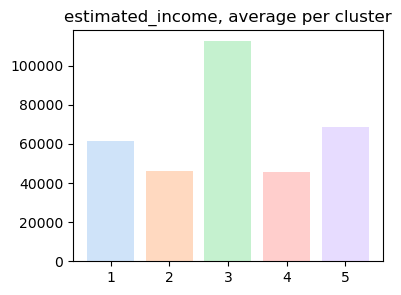

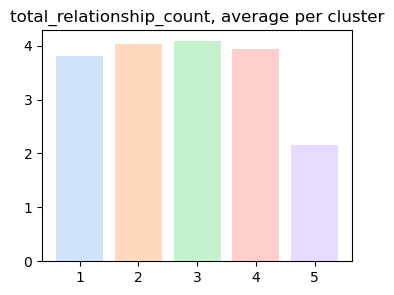

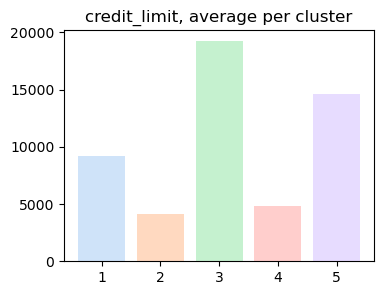

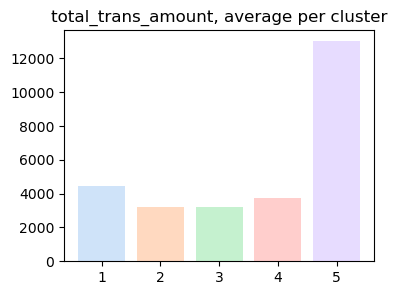

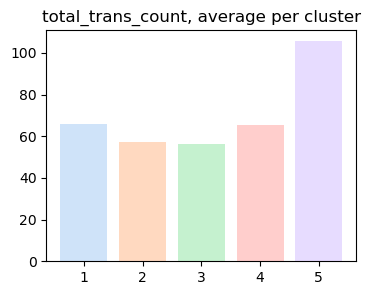

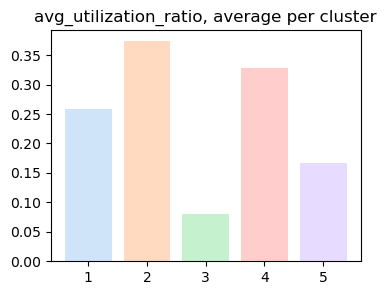

In [20]:
# Selecting features
cols_distinct = ['estimated_income',
                    'total_relationship_count',
                    'credit_limit',
                    'total_trans_amount',
                    'total_trans_count',
                    'avg_utilization_ratio']

# Importing Seaborn library
import seaborn as sns

# Plotting the results
for col in cols_distinct:
    plt.figure(figsize=(4,3))
    plt.bar(customers_grouping.index, customers_grouping[col], color=sns.color_palette("pastel"), alpha=0.5)
    plt.title(col + ', average per cluster')
    plt.show()

Next, we plot pairwise scatterplots of the variables with the highest correlations by cluster.

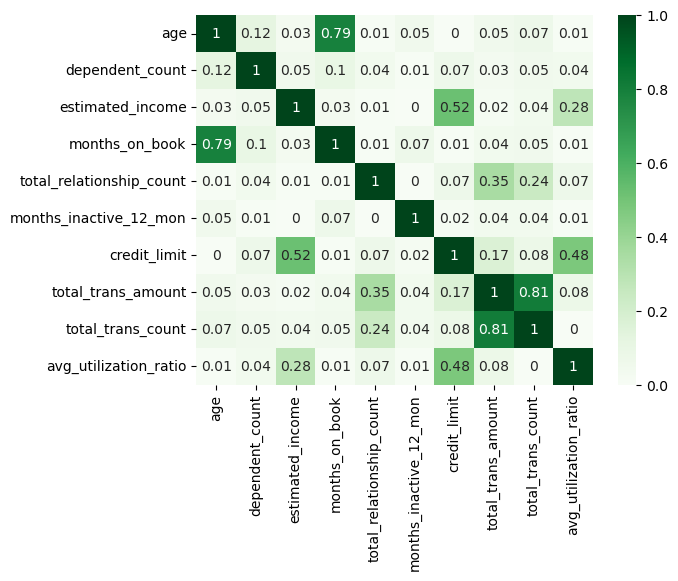

<Figure size 2500x2500 with 0 Axes>

In [21]:
# Building the correlation matrix
customers_corr = customers.drop(['customer_id', 'cluster'], axis=1).corr()

# Plotting the pairwise correlations' heatmap
sns.heatmap(abs(round(customers_corr, 2)), cmap='Greens', annot=True)
plt.figure(figsize=(25,25))
plt.show()

We will plot pairwise scatterplots of credit limit vs. utilization, credit limit vs. estimated income, total number of transactions vs. transaction amount.

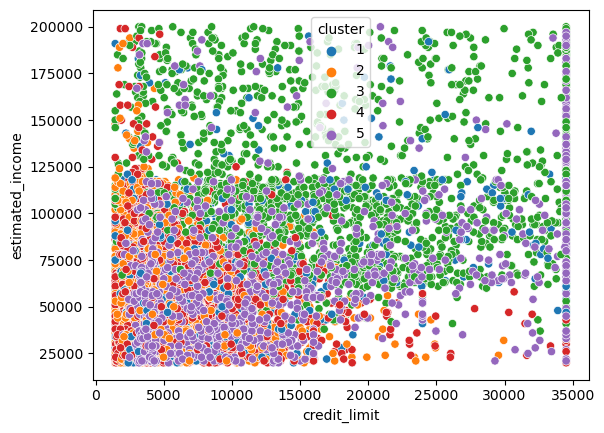

In [22]:
sns.scatterplot(x='credit_limit', y='estimated_income',
               hue='cluster',
               data=customers,
                palette='tab10')
plt.show()

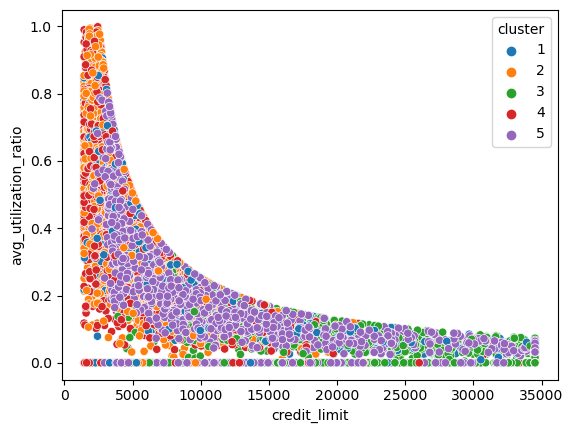

In [23]:
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio',
               hue='cluster',
               data=customers,
                palette='tab10')
plt.show()

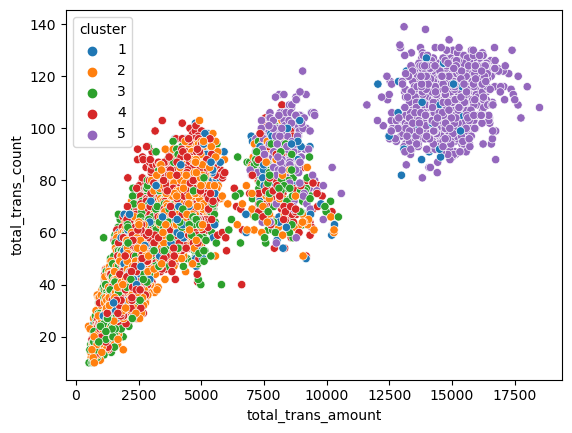

In [24]:
sns.scatterplot(x='total_trans_amount', y='total_trans_count',
               hue='cluster',
               data=customers,
                palette='tab10')
plt.show()

We can make some early conclusions about our clusters based on the numerical characteristics:
- Cluster 1 can be described as clients with near-average scores on all characteristics.
- Clusters 2 and 4 are low-income customers with low credit limits and high daily utilization rates.
- Cluster 3 consists of customers with the highest estimated incomes, who have the highest credit limits, but don't use their cards much, as evidenced by low utilization rates and low numbers and amounts of transactions.
- Cluster 5 consists of middle-income customers with good credit limits and the highest number and amount of transactions.

For categorical variables, we plot the percentage distribution of each feature per cluster.

<Figure size 300x300 with 0 Axes>

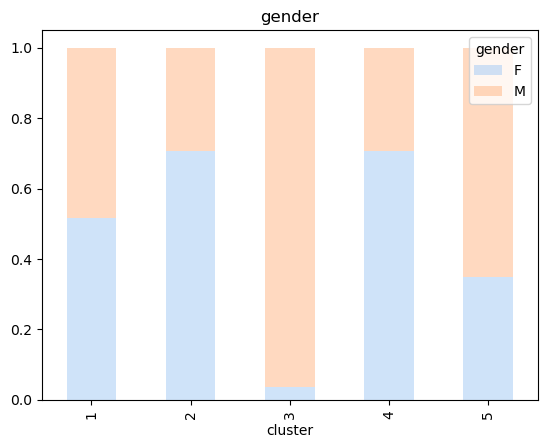

<Figure size 300x300 with 0 Axes>

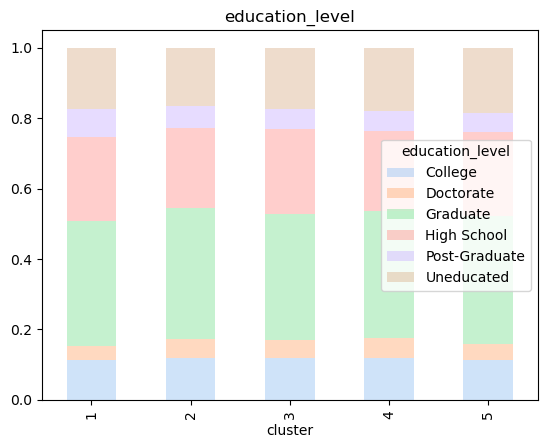

<Figure size 300x300 with 0 Axes>

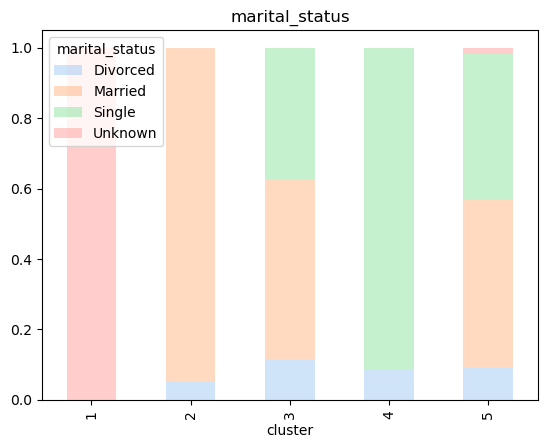

In [25]:
# Selecting categorical variables
customers_cat = customers.select_dtypes(include='object')

# Plotting the distribution of each variable by cluster
for col in customers_cat.columns:
    
    plt.figure(figsize=(3,3))
    pd.crosstab(index=customers['cluster'],
                columns=customers[col],
                values=customers[col],
                aggfunc='size',
                normalize='index').plot.bar(stacked=True,
                                            color=sns.color_palette("pastel"),
                                            alpha=0.5)
    plt.title(col)
    plt.show()

Based on the categorical variables, we can see that clusters 3 and 5 consist mainly of male clients, while clusters 2 and 4 consist of female clients. The clients of cluster 2 are mainly married, those of clusters 3 and 5 are either married or single, those of cluster 4 are almost all single, and the marital status of the clients of cluster 1 is unknown. The level of education is the same for all clusters.

# Conclusion

This project set out to segment credit card customers into groups in order to develop targeted business strategies for each type of client. Using K-means clustering on key customer attributes like income, credit limit, usage, and demographics, the analysis identified 5 distinct customer segments.

Cluster 1 - Average Clients
This cluster consists of clients with average values across all features. They appear to be the typical credit card users without any distinguishing characteristics.

Cluster 2 - Low Income Married Female Clients
This cluster contains low income married female clients, with low credit limits and high utilization rates. They represent a high-risk group due to their heavy reliance on credit cards despite limited income. 

Cluster 3 - High Income Male Clients  
Clients in this cluster have the highest income levels, credit limits, and lowest utilization rates. They are predominantly male, married or single, and represent prime customers for high-end card offers and rewards programs.

Cluster 4 - Low Income Single Female Clients
These clients are low income single females with low credit limits who heavily utilize their cards. They too represent a high-risk group and may benefit from financial counseling or modified card terms.

Cluster 5 - Middle Income Mixed Gender Clients
These clients have middle income, good credit limits, and make the highest number and amount of transactions. The cluster consists of roughly 1/3 females and 2/3 males, married or single. They are active credit card users who may be good targets for balance transfer offers.

In summary, the customer segmentation provided actionable insights for credit risk management, marketing opportunities, and customer support strategies. Using machine learning techniques to cluster granular customer data can unlock customized solutions that maximize business value. The method demonstrated here can be applied in a variety of commercial contexts to improve strategic planning through data-driven understanding of target audiences.

In [26]:
# List of customers and clusters
customers[['customer_id', 'cluster']]

,customer_id,cluster
0,768805383,3
1,818770008,4
2,713982108,3
3,769911858,1
4,709106358,2
...,...,...
10122,772366833,5
10123,710638233,4
10124,716506083,2
10125,717406983,1
